# Web-scraping: сбор данных из баз данных и интернет-источников

*Алла Тамбовцева*

## Практикум 3. Обработка текста и облака слов

### Часть 1: подготовка к работе

В этом практикуме мы будем работать с текстами новостей науки, которые мы ранее научились выгружать со страницы сайта [nplus1.ru](https://nplus1.ru/). В частности, построим на основе текстов облака слов (*word clouds*), которые показывают, какие слова встречаются в тексте чаще, а какие – реже.

Установим необходимые библиотеки:

* библиотека `wordcloud` для построения облака слов ([тьюториал](https://www.datacamp.com/tutorial/wordcloud-python) по работе с библиотекой);
* библиотека `pymorphy2` для морфологического анализа текстов, понадобится для приведения слов к начальной форме ([документация](https://pymorphy2.readthedocs.io/en/stable/)). 

In [ ]:
!pip install --upgrade pip
!pip install --upgrade wordcloud 
!pip install --upgrade pymorphy2 

Команда `pip install ...`  используется для установки библиотек, к ней можно добавить опцию `--upgrade` на случай, если библиотека на компьютере уже установлена в более старой версии, а мы хотим её обновить. Символ `!` в начале строки сообщает Jupyter, что это особая операция, как будто бы запускаемая с командной строки или из терминала, а не код Python с соответствующим синтаксисом. Строка с установкой `pip` в самом начале нужна для обновления самого установщика `pip` (если версия установщика старая, логично, что он не все новые версии библиотек сможет корректно поставить).

Импортируем библиотеки, чтобы убедиться, что всё установилось (для надёжности можно перезапустить ядро через *Kernel - Restart* и после импортировать):

In [1]:
import wordcloud
import pymorphy2

Проверили, теперь давайте импортируем из библиотек отдельные функции (глобальный импорт выше можно в дальнейшем пропускать и импортировать только отдельные функции):

* функция (класс, кто знаком с ООП в Python) `WordCloud` для создания объекта типа *облако слов*;
* функция (тоже класс) `MorphAnalyzer` для создания объекта типа *морфологический анализатор*;
* модуль `pyplot` из библиотеки `matplotlib` для построения графиков.

In [2]:
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from matplotlib import pyplot as plt

Проверим, что всё работает, на маленьком тексте:

In [3]:
# фрагмент из «Макбета» У.Шекспира
# всё в нижнем регистре без знаков препинания

test = """
кто вы ответьте если речь дана вам
хвала тебе макбет гламисский тан
хвала тебе макбет кавдорский тан
хвала макбету королю в грядущем
"""

Давайте разобьём текст на отдельные слова и приведём их к единой начальной форме! Так, все существительные будут стоять в единственном числе в именительном падеже, все прилагательные – тоже в единственном числе в именительном падеже, но ещё и в мужском роде, глаголы – в неопределённой форме. Эта процедура называется **лемматизацией** (*лемма* – словарная форма слова). Иногда для унификации слов используют другую процедуру – **стемминг** (от английского *stem* – основа), которая предполагает отсечение всех формообразующих морфем вроде окончаний и суффиксов глаголов, но для нашей цели она не подходит – слова в облаке слов будут некрасиво обрублены.

Разбиваем текст на слова:

In [4]:
words = test.split()
print(words)

['кто', 'вы', 'ответьте', 'если', 'речь', 'дана', 'вам', 'хвала', 'тебе', 'макбет', 'гламисский', 'тан', 'хвала', 'тебе', 'макбет', 'кавдорский', 'тан', 'хвала', 'макбету', 'королю', 'в', 'грядущем']


Создаем объект типа «морфологический анализатор», он поможет автоматически сделать морфологический разбор слова и забрать его начальную форму:

In [5]:
morph = MorphAnalyzer()

Посмотрим на работу анализатора на примере одного слова (разбор слова или предложения в обработке текста и лингвистике тоже называется парсинг, так как парсинг вообще – это автоматический разбор какой-то структуры):

In [6]:
morph.parse("стекла")

[Parse(word='стекла', tag=OpencorporaTag('NOUN,inan,neut sing,gent'), normal_form='стекло', score=0.828282, methods_stack=((DictionaryAnalyzer(), 'стекла', 157, 1),)),
 Parse(word='стёкла', tag=OpencorporaTag('NOUN,inan,neut plur,nomn'), normal_form='стекло', score=0.080808, methods_stack=((DictionaryAnalyzer(), 'стёкла', 157, 6),)),
 Parse(word='стёкла', tag=OpencorporaTag('NOUN,inan,neut plur,accs'), normal_form='стекло', score=0.080808, methods_stack=((DictionaryAnalyzer(), 'стёкла', 157, 9),)),
 Parse(word='стекла', tag=OpencorporaTag('VERB,perf,intr femn,sing,past,indc'), normal_form='стечь', score=0.010101, methods_stack=((DictionaryAnalyzer(), 'стекла', 1015, 2),))]

Метод `.parse()` вернул список всех возможных вариантов разбора слова, упорядоченный от наиболее вероятного до наименее вероятного. Так, с самой большой вероятностью слово «стекла» – это родительный падеж слова «стекло» (`NOUN` – существительное, `inan` – неодушевленное, `sing` – единственное число, `gent` – родительный падеж, генитив). А с самой маленькой вероятностью это слово является формой глагола «стечь» (`VERB` – глагол, `perf` – прошедшее время, `intr` – непереходный глагол, `indc` – изъявительное наклонение, индикатив).

Из списка можно извлечь самый вероятный первый разбор и забрать его начальную форму:

In [7]:
morph.parse("стекла")[0].normal_form

'стекло'

Задействуем списковое включение и получим для каждого слова в `test` начальную форму:

In [8]:
words_norm = [morph.parse(w)[0].normal_form for w in words]
print(words_norm)

['кто', 'вы', 'ответить', 'если', 'речь', 'дать', 'вы', 'хвала', 'ты', 'макбет', 'гламисский', 'тан', 'хвала', 'ты', 'макбет', 'кавдорский', 'тан', 'хвала', 'макбет', 'король', 'в', 'грядущий']


Теперь снова склеим слова в единый текст – для облака слов список не подойдёт:

In [9]:
test_norm = " ".join(words_norm)
print(test_norm)

кто вы ответить если речь дать вы хвала ты макбет гламисский тан хвала ты макбет кавдорский тан хвала макбет король в грядущий


Построим облако слов с помощью `WordCloud()`:

In [10]:
# wcloud – объект, в котором хранится информация для построения облака
# временно соханен в какой-то ячейке памяти

wcloud = WordCloud().generate(test_norm)
wcloud

Если выводятся странные ошибки, попробуйте установить более старую версию библиотеки `Pillow`, от неё зависят некоторые процедуры в `wordcloud`: `!pip install Pillow==9.5.0`.

Теперь отрисуем полученное облако через функцию `.imshow()` и «выключим» оси, так как метки с числами (как на обычных графиках) нам не нужны:

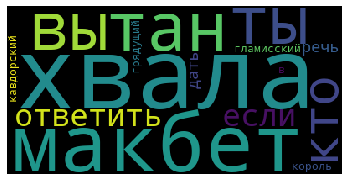

In [11]:
plt.imshow(wcloud)
plt.axis("off")
plt.show()

Проблема: облако слов получилось неинформативным! В нём, действительно, собраны самые частые слова вроде союзов, а мы явно хотели не этого. На самом деле, наша предварительная обработка текста была выполнена не до конца – мы забыли убрать так называемые **стоп-слова**, самые частые слова в языке, которые обычно исключаются перед анализом текстов. Вариантов добыть стоп-слова для русского языка много: можно подключить специальные бибиотеки вроде `nltk`, можно загрузить список из репозитория какого-нибудь проекта на Github или из готового файла. 

Для этого маленького текста мы просто сформируем список стоп-слов вручную:

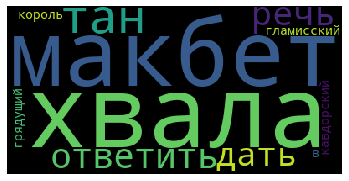

In [12]:
stop = ["кто", "ты", "вы", "если"]

# аргумент stopwords внутри WordCloud()

wcloud = WordCloud(stopwords = stop).generate(test_norm)
plt.imshow(wcloud)
plt.axis("off")
plt.show()

Итак, простые облака слов мы строить научились, перейдём к более интересным текстам новостей.

### Часть 2: облака слов для новостей

Импортируем библиотеку `pandas` и считаем данные из csv-файла с выгруженными ранее новостями науки:

In [13]:
import pandas as pd

In [14]:
news = pd.read_csv("nplus1_upd.csv")
news.head()

,Unnamed: 0,title,author,date,diffc,rubrics,text,rubric01,rubric02,rubric03,rubric04,rubric05
0,0,Австралийских комаров-кусак обвинили в распрос...,2024-01-27,Слава Гоменюк,3.2,Медицина,Австралийские ученые провели обширный анализ р...,Медицина,NaN,NaN,NaN,NaN
1,1,Нейросеть научили определять симметричность гр...,2024-01-27,Олег Лищук,1.5,Медицина,Испанские исследователи обучили нейросеть с вы...,Медицина,NaN,NaN,NaN,NaN
2,2,Снижение веса сохранилось через год после курс...,2024-01-27,Олег Лищук,1.8,Медицина,Американские исследователи проанализировали ба...,Медицина,NaN,NaN,NaN,NaN
3,3,Львы стали реже охотиться на зебр из-за распро...,2024-01-27,Сергей Коленов,4.1,"Зоология, Экология и климат","Ученые выяснили, что появление в Восточной Афр...",Зоология,Экология и климат,NaN,NaN,NaN
4,4,Георадар «Персеверанса» увидел древнюю эрозию ...,2024-01-26,Винера Андреева,4.6,Астрономия,Планетологи представили результаты анализа гео...,Астрономия,NaN,NaN,NaN,NaN


Выберем столбец `text` с текстами новостей и склеим все новости в единый текст:

In [15]:
full = "".join(news["text"])

Приведём всё к нижнему регистру (маленьким буквам):

In [16]:
full = full.lower()

Уберём знаки препинания – воспользуемся готовым перечнем из модуля `string`:

In [17]:
from string import punctuation

In [18]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Объект `punctuation` – самая обычная строка со знаками препинания. Доклеим к ней недостающие символы – длинное тире и русские кавычки «ёлочки» (да, это вполне официальное название, английские кавычки называются «лапками»):

In [19]:
punctuation = punctuation + "—" + "«»" 

Теперь осуществим замену – заменим все знаки препинания в тексте (из `punctuation`) на пробелы:

In [20]:
for p in punctuation:
    full = full.replace(p, " ")
    
# фрагмент текста
print(full[0:98])

австралийские ученые провели обширный анализ распространенности возбудителя язвы бурули mycobacter


Дальнейшую обработку текста проведём по аналогии с предыдущим примером.

### Задача 1

Разбейте текст `full` на список слов и приведите все слова к начальной форме с помощью `pymorphy2`. Сохраните текст, состоящий из слов в начальной форме, в переменную `full_norm`.

In [21]:
full_list = full.split()
full_norm_list = [morph.parse(w)[0].normal_form for w in full_list]
full_norm = " ".join(full_norm_list)

### Задача 2

Загрузите из файла `stop_words_russian.txt` стоп-слова и сохраните их в список `stop_ru`. 

In [22]:
f = open("stop_words_russian.txt")
lines = f.readlines()

In [23]:
stop_ru = [line.strip() for line in lines]

### Задача 3

Постройте облако слов для текста `full_norm` так, чтобы стоп-слова из `stop_ru` в облако не были внесены. 

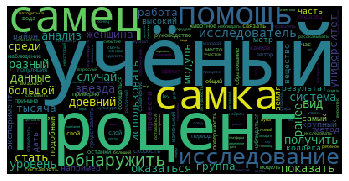

In [24]:
wcloud = WordCloud(stopwords = stop_ru).generate(full_norm)
plt.imshow(wcloud)
plt.axis("off")
plt.show()

### Задача 4

Напишите функцию `prepare_for_cloud()`, которая принимает на вход строку с текстом для визуализации, а возвращает строку с обработанным текстом (текст в нижнем регистре, без знаков препинания, слова в начальной форме).

In [25]:
from string import punctuation
punctuation = punctuation + "—" + "«»" 

def prepare_for_cloud(full):
    full = full.lower()
    for p in punctuation:
        full = full.replace(p, " ")
    full_list = full.split()
    full_norm_list = [morph.parse(w)[0].normal_form for w in full_list]
    full_norm = " ".join(full_norm_list)
    return full_norm

### Часть 3: немного интерактива и настройка дизайна облака слов

Давайте добавим фильтр на рубрику новостей – запросим значение с клавиатуры у пользователя:

In [26]:
rub = input()

Физика


Отфильтруем соответствующие строки из таблицы:

In [27]:
chosen = news[news["rubrics"].str.contains(rub)]

### Задача 5

Постройте облако слов для новостей выбранной рубрики, используя функцию `prepare_for_cloud()` для предварительной обработки текста. Сделайте фон белым, а в качестве цветовой палитры используйте встроенную палитру `magma`.

In [28]:
ct = " ".join(chosen["text"])
ct_norm = prepare_for_cloud(ct)

**Пояснения к коду с графиком.** Функция `subplots()` создает два объекта:

* «рамка» для картинки (обычно сохраняется в переменную `fig`);
* поле с осями, внутри которого строится график (обычно сохраняется в переменную `ax`).

Неформально, создавая `fig` мы резервируем место под картинку соответствующего размера, а затем проводим различные манипуляции с `ax`, чтобы внутри этого поля для картинки построить график, настроить подписи, оси и прочее. Соответственно, к `ax` мы будем применять различные методы, а по завершении работы сможем выгрузить объект `fig` в файл PNG, JPEG или PDF. Вообще функция `subplots()`, как следует из её названия, может использоваться для построения сразу нескольких графиков, но у нас пока внутри `fig` будет один.

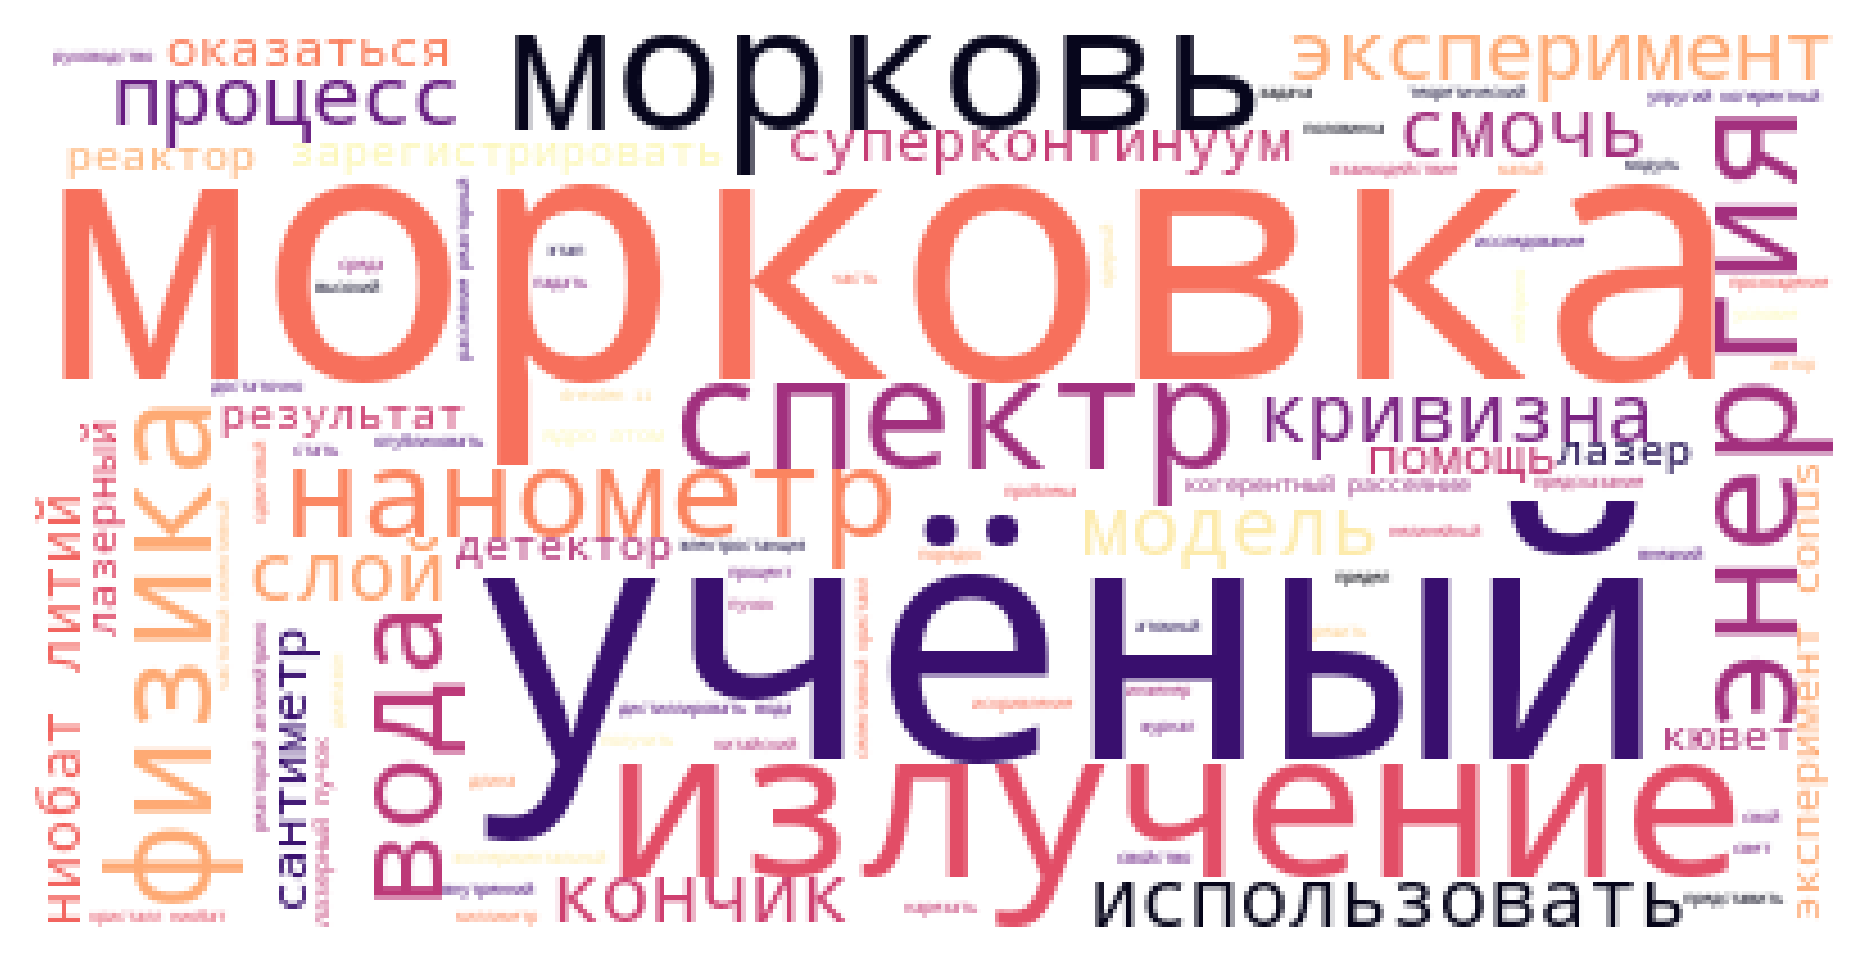

In [32]:
# figsize - размер в дюймах, делаем 16 на 9
# dpi, от dots per inch – разрешение 300 точек на дюйм (это хорошо даже для печати)

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

### YOUR CODE HERE ###

wcloud = WordCloud(stopwords = stop_ru, background_color = "white", colormap = "magma").generate(ct_norm)
plt.imshow(wcloud)
plt.axis("off")
plt.show()

**Дополнение.** Разрешение в итоге получилось не очень хорошим, нужно синхронизировать размер облака в `WordCloud()` и `subplots()`. 
В `WordCloud()` можно добавить ширину и высоту изображения с облаком (в пикселях), чтобы оно было побольше (по умолчанию 400 на 200):

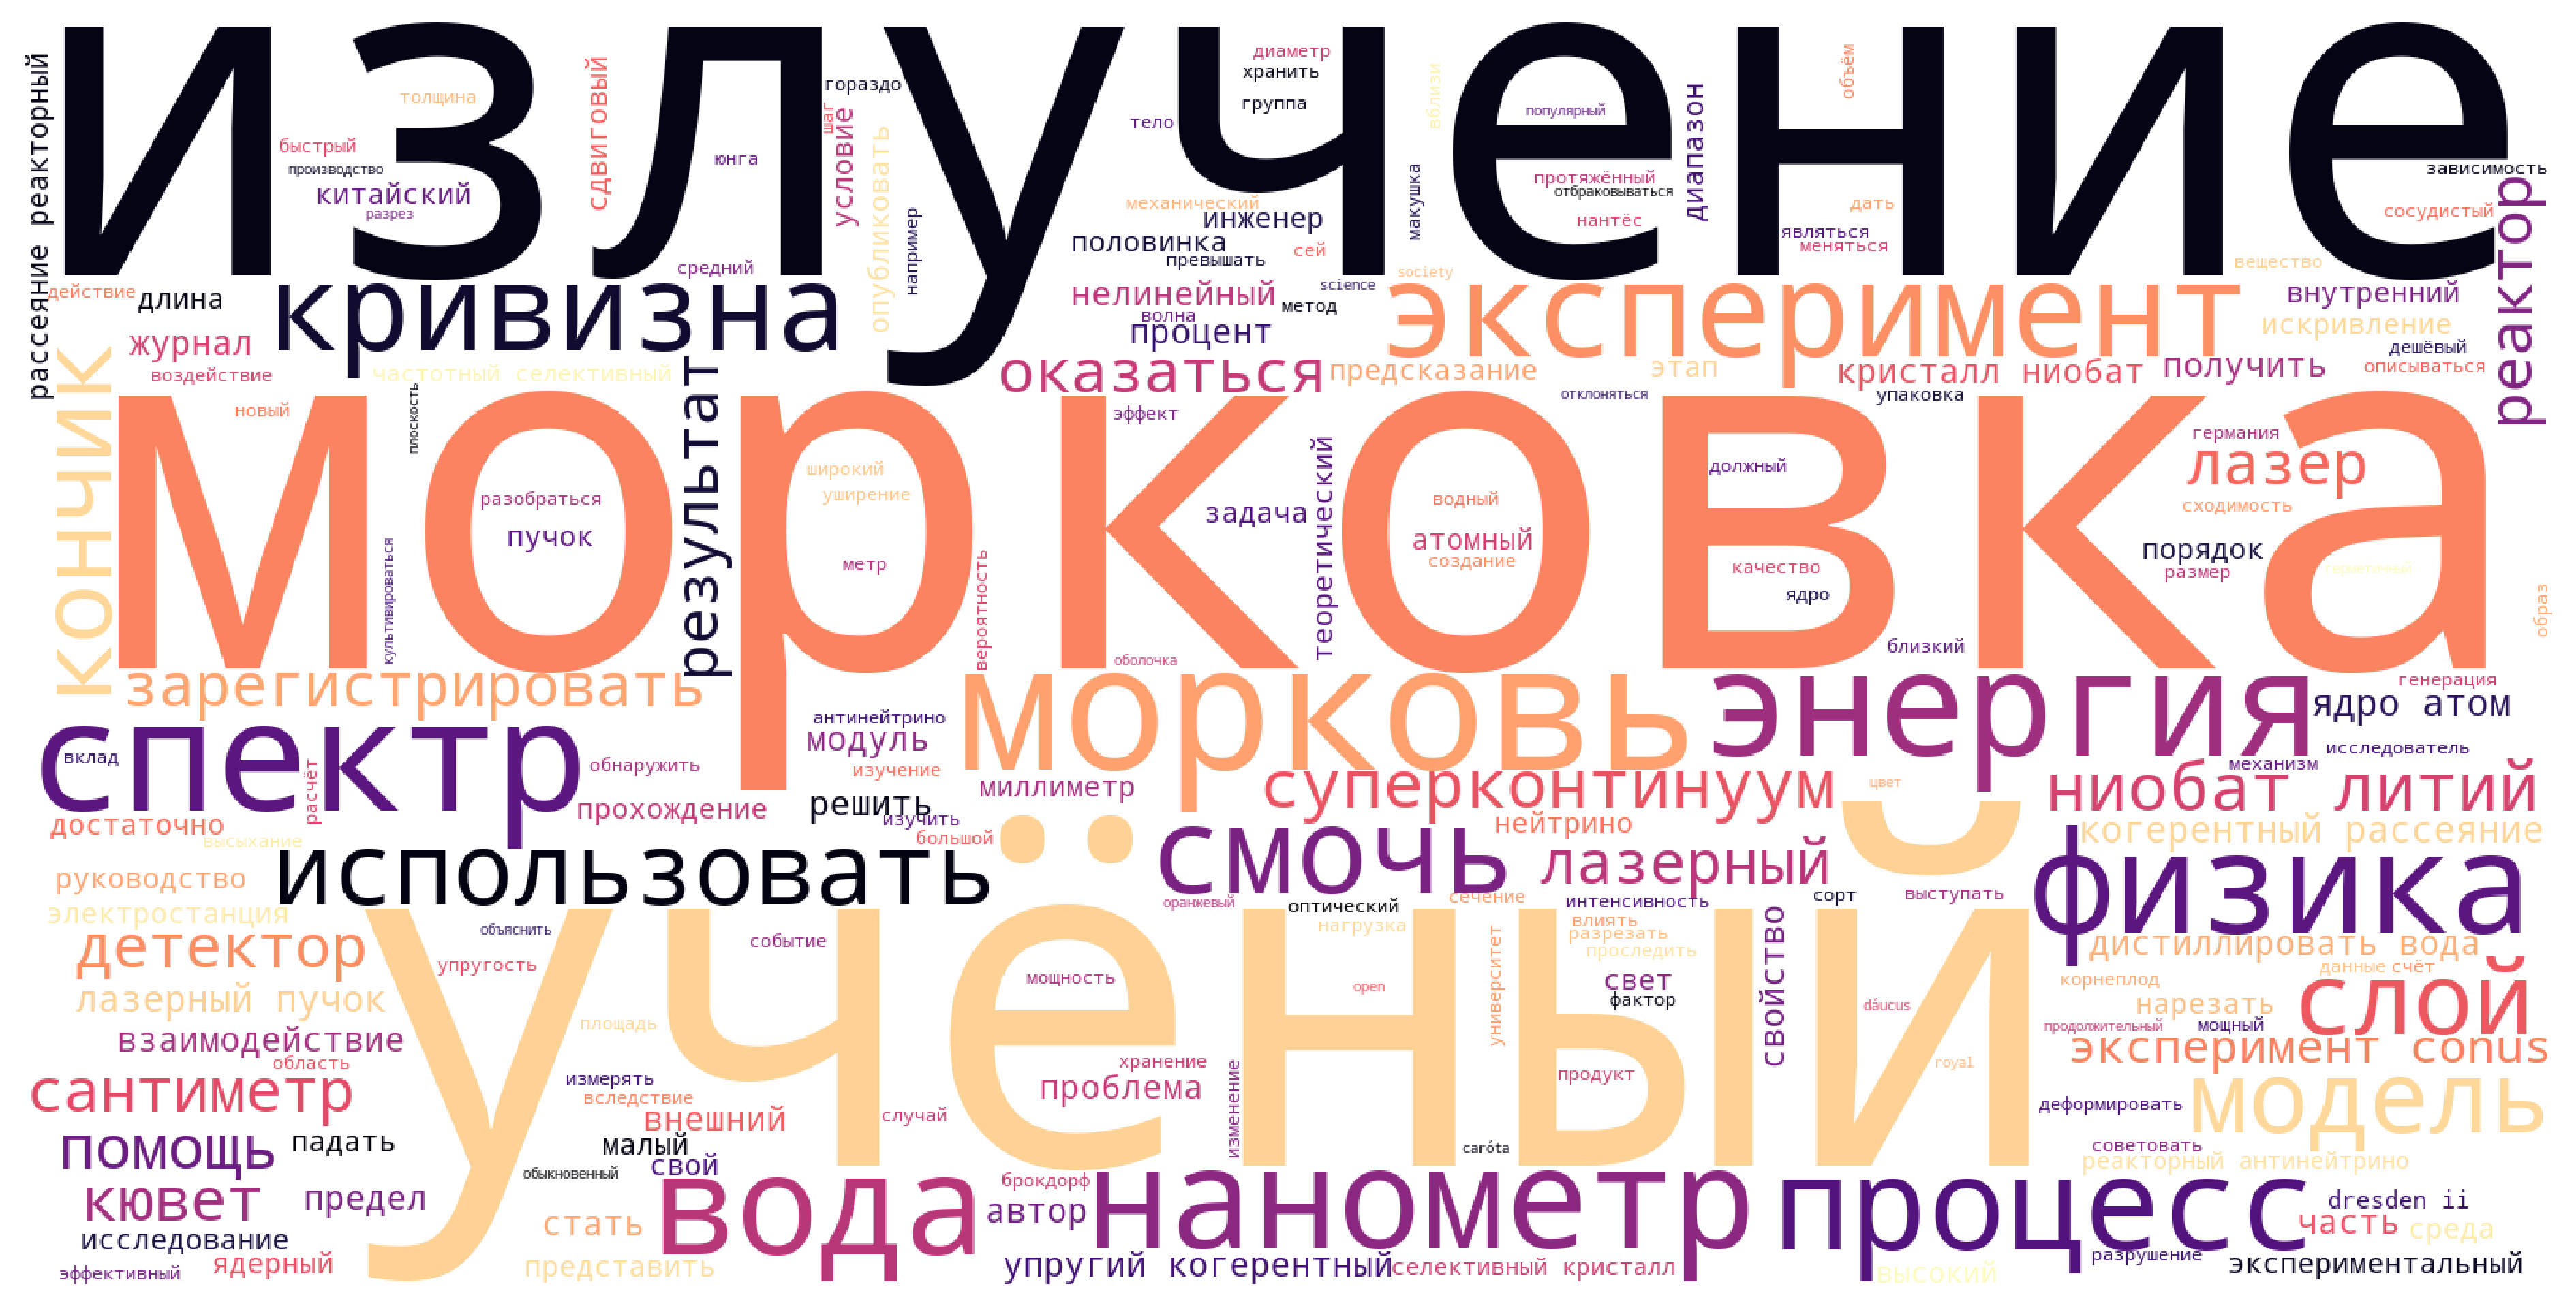

In [34]:
wcloud = WordCloud(stopwords = stop_ru, 
                   background_color = "white", 
                   colormap = "magma",
                   width = 1600, height = 800).generate(ct_norm)

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

plt.imshow(wcloud)
plt.axis("off")
plt.show()

# можно добавить для выгрузки в файл, будет рядом с текущим ipynb

fig.savefig("cloud01.png")

В качестве основы для облака слов можно взять изображение, это прекрасно описано в тьюториале [здесь](https://www.datacamp.com/tutorial/wordcloud-python). Подобрать какое-то узнаваемое и простое по форме тематическое изображение в данном случае сложновато, поэтому давайте просто возьмём векторное изображение с [Freepik](https://ru.freepik.com/).

Импортируем функцию для обработки изображения и библиотеку `numpy`, чтобы потом преобразовать изображение в числовой массив:

In [35]:
from PIL import Image
import numpy as np

Загружаем изображение и создаём массив:

In [36]:
my_mask = np.array(Image.open("42517.jpg"))

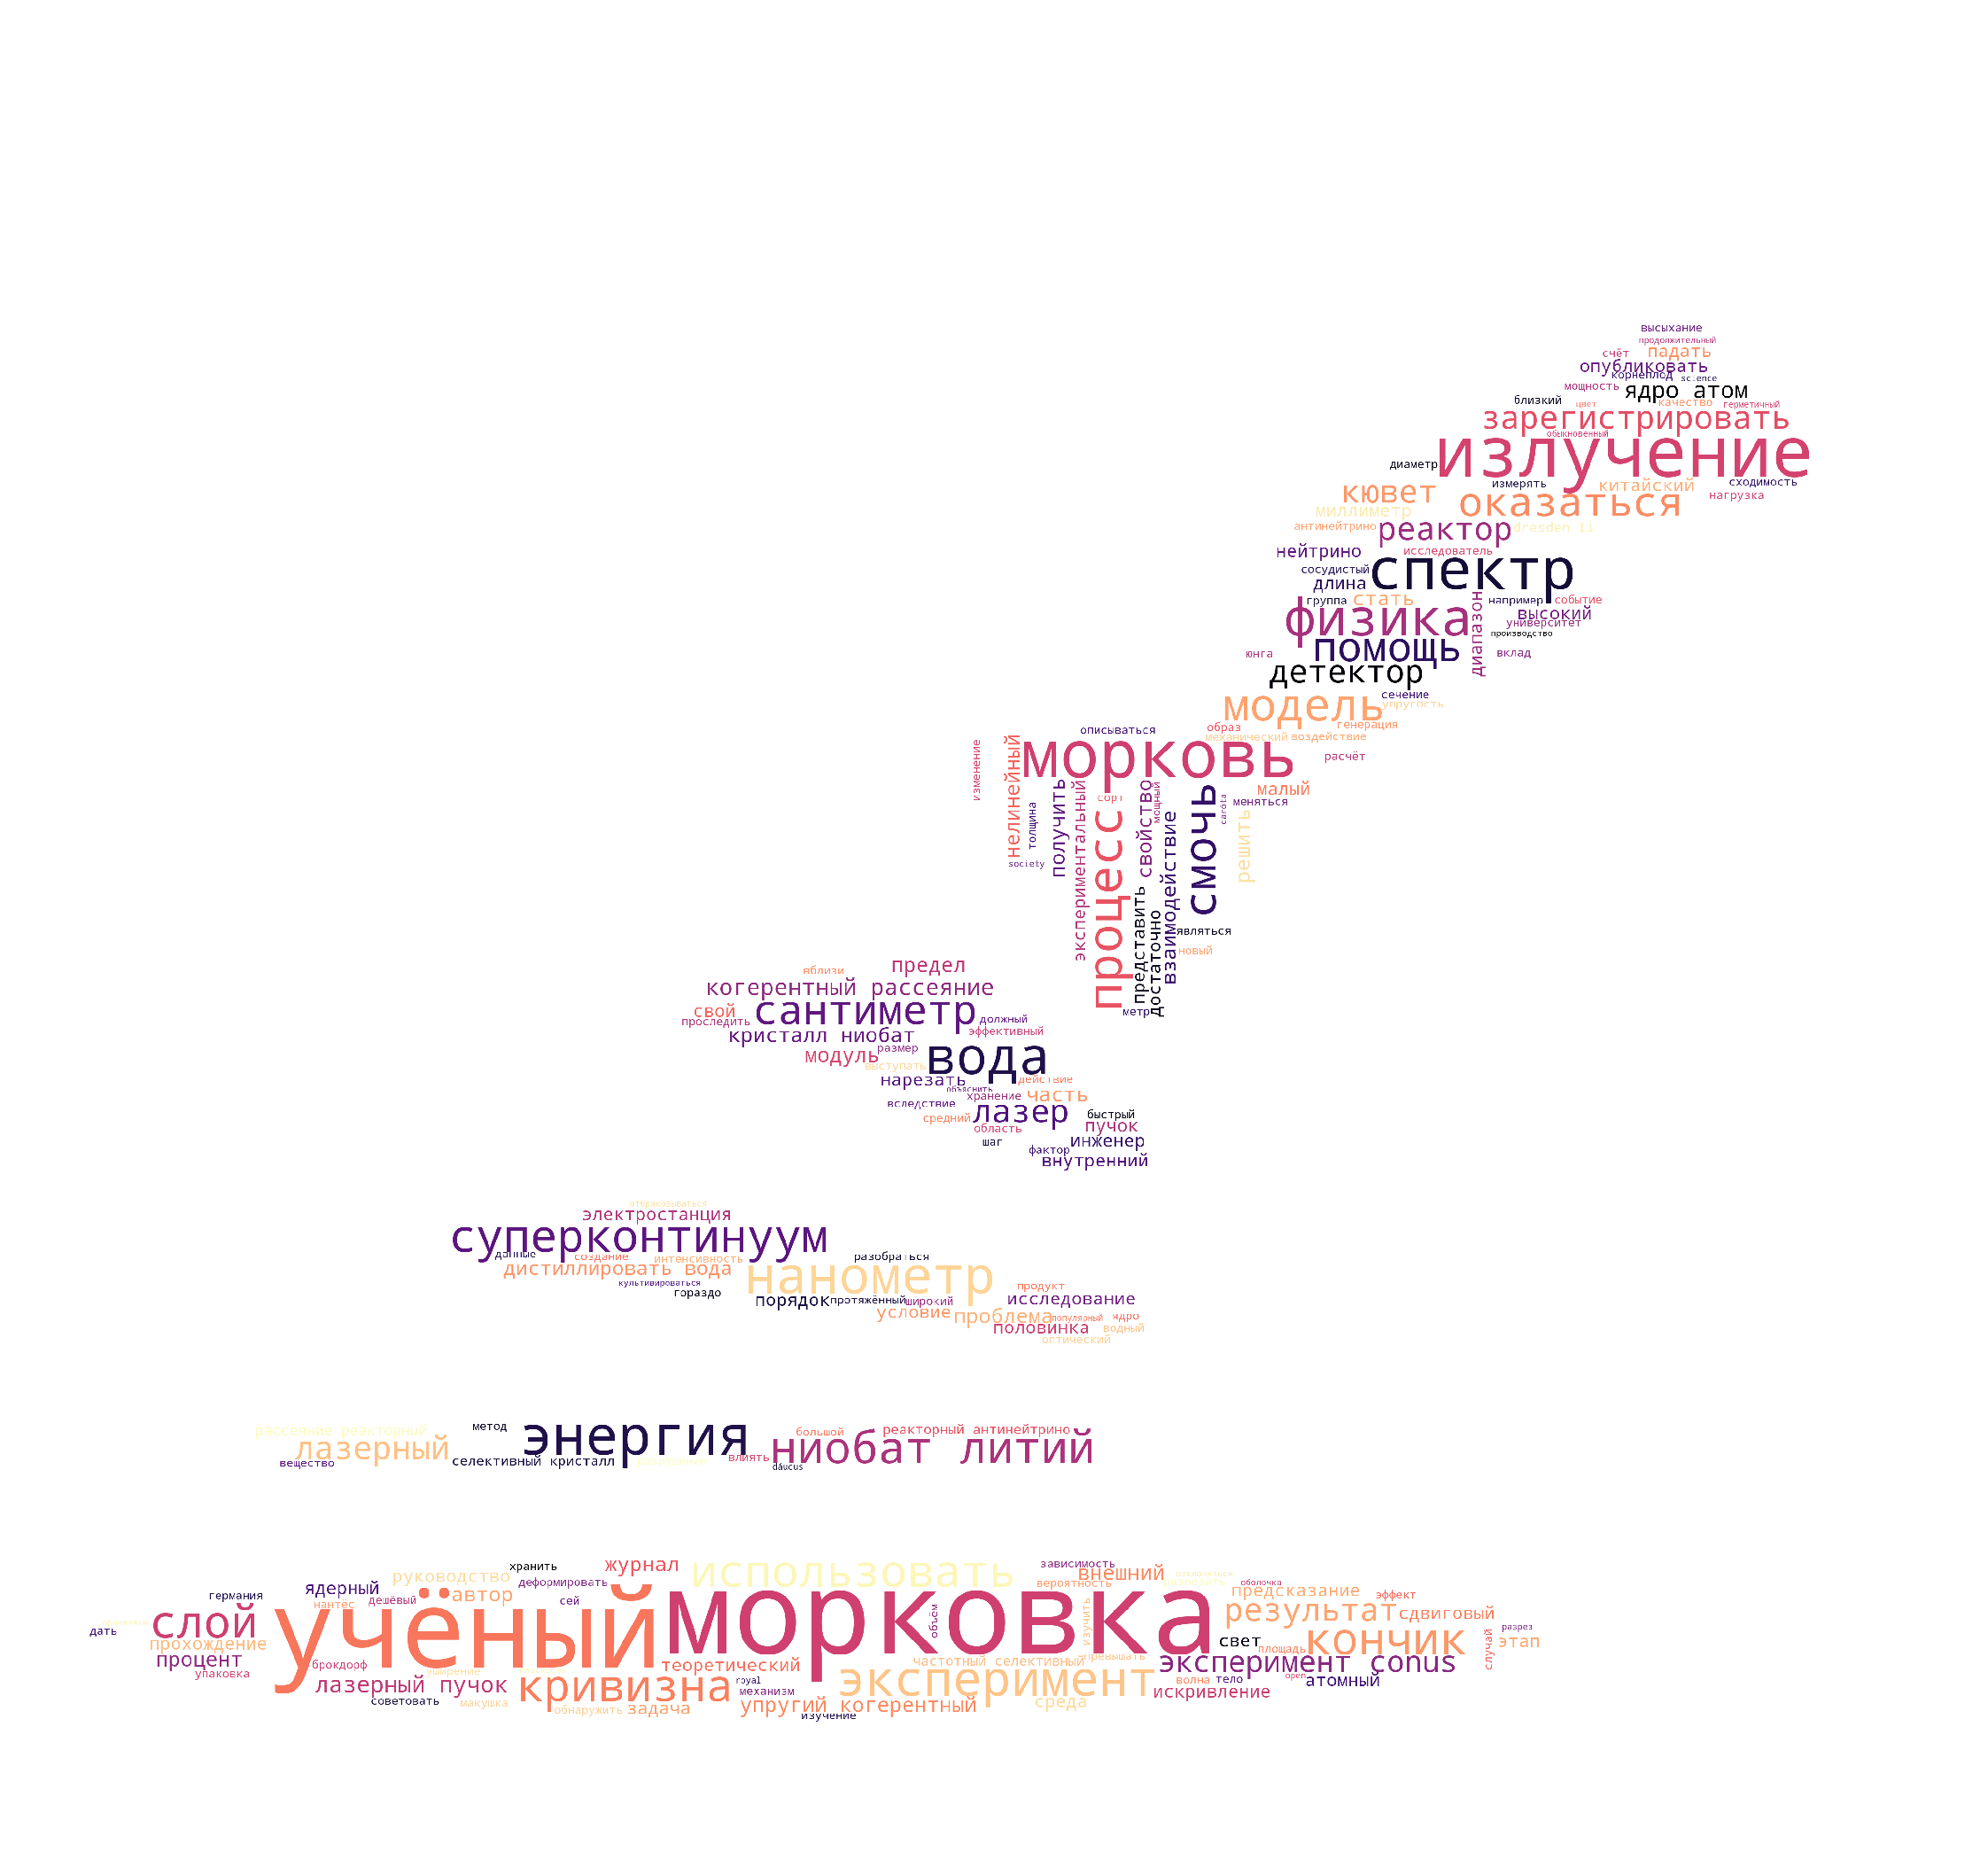

In [37]:
wcloud = WordCloud(stopwords = stop_ru, 
                   background_color = "white", 
                   colormap = "magma",
                   width = 1600, height = 800,
                   mask = my_mask).generate(ct_norm)

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 
plt.imshow(wcloud)
plt.axis("off")
plt.show()

# можно добавить для выгрузки в файл, будет рядом с текущим ipynb

fig.savefig("cloud02.png")